<a href="https://colab.research.google.com/github/marcinwolter/Higgs_Janka/blob/main/Higgs_Janka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higgs analysis of Janka

author: Marcin Wolter, February 2021

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Read the cvs input data from google disk and create DataFrame

IMPORTANT: from background only a part of events is read (we read an equal number of signal and background events)

In [24]:
# Read csv data

from google.colab import drive
drive.mount('/content/drive')

masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]

bckg = []
sig = []
for i in range(len(masses)):
  bckg_str = '/content/drive/MyDrive/jkrzysiak/data/Ztautau_'+str(masses[i])+'GeV.csv'
  bckg.append(pd.read_csv(bckg_str) )
  sig_str = '/content/drive/MyDrive/jkrzysiak/data/signal_'+str(masses[i])+'GeV.csv'
  sig.append(pd.read_csv(sig_str) )


#print(bckg)

XX = []
YY = []
WEIGHT = []

for i in range(len(masses)):
  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']]
  xsw= sig[i][['weight']]
  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']].head(len(xs))
  xbw= bckg[i][['weight']].head(len(xs))
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["class"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["class"])

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  print(x.shape, y.shape, w.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(171462, 6) (171462, 1) (171462, 1)
(193622, 6) (193622, 1) (193622, 1)
(235270, 6) (235270, 1) (235270, 1)
(264860, 6) (264860, 1) (264860, 1)
(285392, 6) (285392, 1) (285392, 1)
(309108, 6) (309108, 1) (309108, 1)
(238850, 6) (238850, 1) (238850, 1)
(237492, 6) (237492, 1) (237492, 1)
(234264, 6) (234264, 1) (234264, 1)
(172570, 6) (172570, 1) (172570, 1)
(132800, 6) (132800, 1) (132800, 1)
(110962, 6) (110962, 1) (110962, 1)
(94298, 6) (94298, 1) (94298, 1)


Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 

IMPORTANT: training dataset has only 1,000,000 events.



In [25]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=2000000, shuffle=True, random_state=42)



(2680950, 6) (2680950, 1) (2680950, 1)


Prepare a small fully connected network

In [26]:
# prepare keras model

def define_model():
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(6,)))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [27]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")
  metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=metrics)
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=6,
    verbose=1
  )

  epochs = 100
  batch_size=128
  print("fitting")
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[es])
  return history, model
#sample_weight = sw_train,

K-folding

In [28]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("fit_model")
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
		# stores scores
    scores.append(acc)
    histories.append(history)
    models.append(model)
  return scores, histories, models

Plot learning curves and summary of training

In [29]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification AUC')
    plt.plot(histories[i].history['auc'], color='blue', label='train')
    plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [30]:
def network_fit(x_train_all, y_train_all, sw_train_all):


  #convert to numpy

  np_x_train_all = x_train_all.to_numpy()
  np_y_train_all = y_train_all.to_numpy()
  np_sw_train_all = sw_train_all.to_numpy()


  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  np_x_train_all = np.array(layer(np_x_train_all))

  # Train the network. 
  n_folds = 3  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [31]:
# Define normalization of input data
layer = preprocessing.Normalization()
layer.adapt(x_train_all.to_numpy())

In [32]:
# train the network
scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

fit_model
compiling
fitting
Epoch 1/100
10417/10417 [==============================] - 44s 4ms/step - loss: 0.4460 - auc: 0.8556 - val_loss: 0.4114 - val_auc: 0.8781
Epoch 2/100
10417/10417 [==============================] - 44s 4ms/step - loss: 0.4188 - auc: 0.8735 - val_loss: 0.4081 - val_auc: 0.8805
Epoch 3/100
10417/10417 [==============================] - 42s 4ms/step - loss: 0.4143 - auc: 0.8765 - val_loss: 0.4026 - val_auc: 0.8852
Epoch 4/100
10417/10417 [==============================] - 42s 4ms/step - loss: 0.4105 - auc: 0.8795 - val_loss: 0.4026 - val_auc: 0.8852
Epoch 5/100
10417/10417 [==============================] - 43s 4ms/step - loss: 0.4085 - auc: 0.8811 - val_loss: 0.3984 - val_auc: 0.8875
Epoch 6/100
10417/10417 [==============================] - 41s 4ms/step - loss: 0.4078 - auc: 0.8816 - val_loss: 0.3986 - val_auc: 0.8873
Epoch 7/100
10417/10417 [==============================] - 42s 4ms/step - loss: 0.4069 - auc: 0.8824 - val_loss: 0.3987 - val_auc: 0.8872
Epoch 

Make plots

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


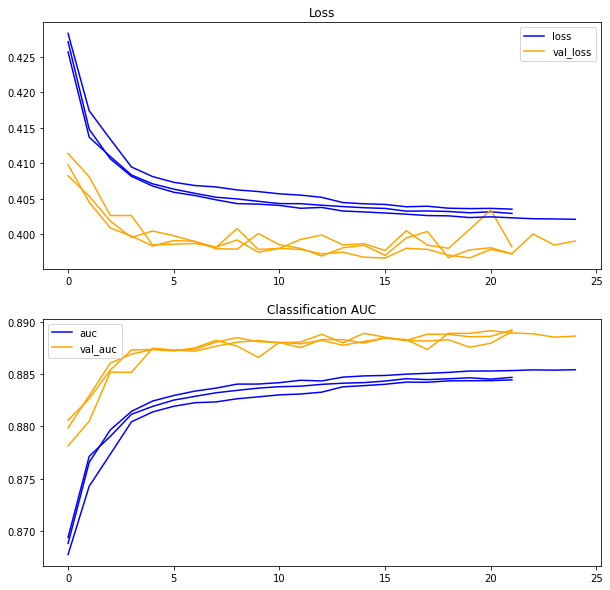

Accuracy: mean=88.897 std=0.025, n=3


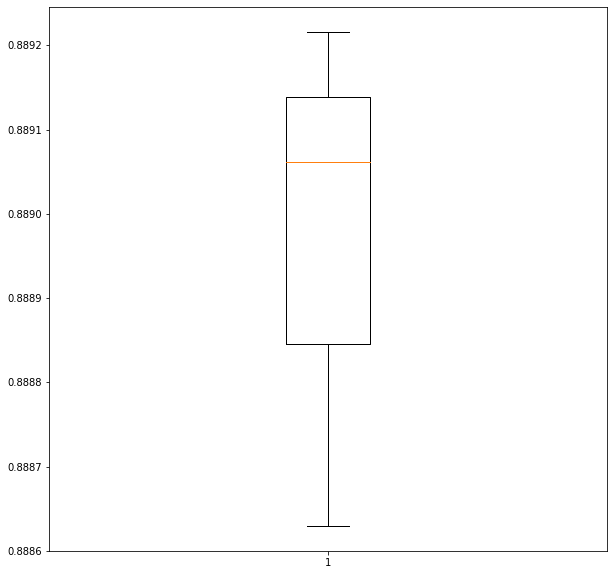

Scores:  [0.8892160654067993, 0.8890619874000549, 0.8886293172836304]


In [33]:
# learning curves
print(histories[1].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Build an ensamble of networks trained using k-folding and test it on test data

---



In [34]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #test data
  np_x_test_all = x_test_all.to_numpy()
  np_y_test_all = y_test_all.to_numpy()
  np_sw_test_all = sw_test_all.to_numpy()

  # normalize test data
  np_x_test_all = np.array(layer(np_x_test_all))


  # make predictions
  yhats = [model.predict(np_x_test_all) for model in models]
  yhats = np.array(yhats)
  # sum across ensembles
  summed = np.sum(yhats, axis=0)/len(models)
  # argmax across classes
  #outcomes = np.argmax(summed, axis=1)

  # true outcomes
  #outcomes_true = np.argmax(np_y_test_all,axis = 1)

  # func to calculate auc

  fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all)


  fpr.sort()
  r_auc = auc(1-fpr[10:], tpr[10:])
  #score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

  print("Ensamble test auc: ",r_auc,"%")


  plt.figure(figsize=(4,4))
  plt.plot(1-fpr,tpr)
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  return r_auc

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200
Ensamble test auc:  0.6840943516607165 %


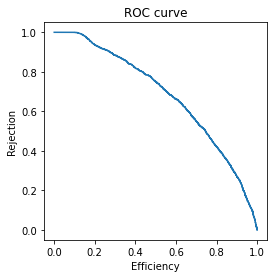

signal_mass =  250
Ensamble test auc:  0.7490718409509672 %


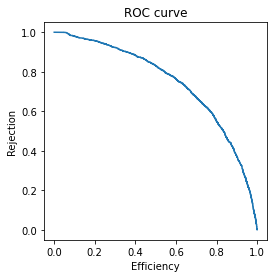

signal_mass =  300
Ensamble test auc:  0.7927685014978032 %


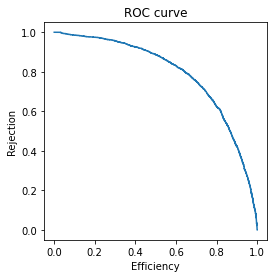

signal_mass =  350
Ensamble test auc:  0.8422502317537272 %


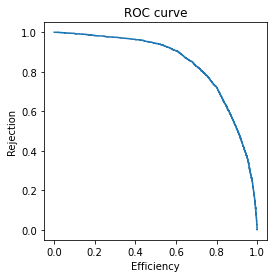

signal_mass =  400
Ensamble test auc:  0.872141011184054 %


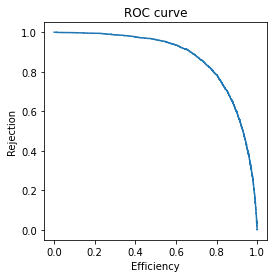

signal_mass =  500
Ensamble test auc:  0.92600962146797 %


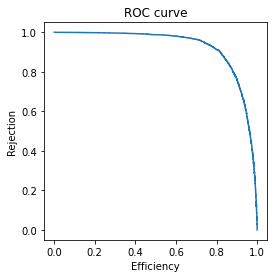

signal_mass =  600
Ensamble test auc:  0.9553459973890951 %


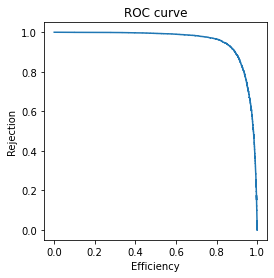

signal_mass =  700
Ensamble test auc:  0.9701850910119905 %


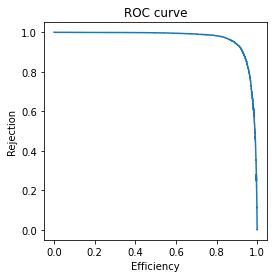

signal_mass =  800
Ensamble test auc:  0.9817338702119516 %


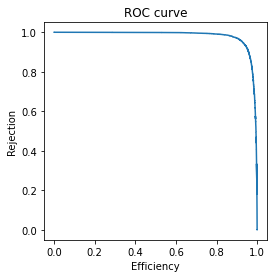

signal_mass =  1200
Ensamble test auc:  0.9947208492355286 %


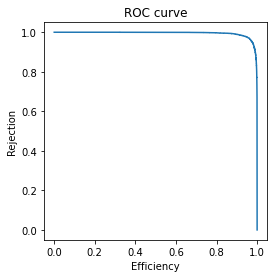

signal_mass =  1500
Ensamble test auc:  0.9988781992786542 %


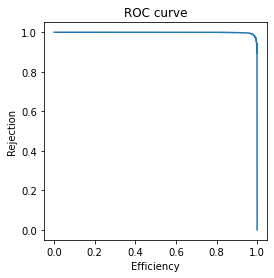

signal_mass =  2000
Ensamble test auc:  0.9996037111159247 %


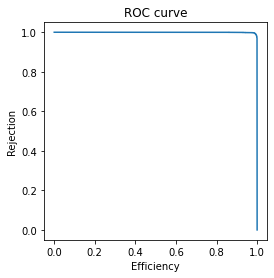

signal_mass =  2500
Ensamble test auc:  0.9998290173465528 %


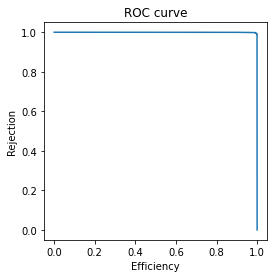

In [35]:
auc_list = []

for m in masses:
  print("signal_mass = ",m)
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  auc_list.append(test_ensamble(x_test_m, y_test_m, sw_test_m))

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

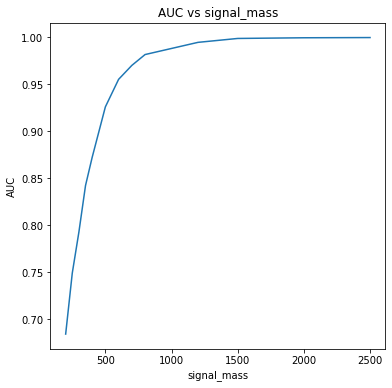

,signal_mass,auc
0,200,0.684094
1,250,0.749072
2,300,0.792769
3,350,0.842250
4,400,0.872141
5,500,0.926010
6,600,0.955346
7,700,0.970185
8,800,0.981734
9,1200,0.994721


In [36]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list)
plt.title('AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list)), 
               columns =['signal_mass', 'auc']) 
aucf

Split test data according to signal_mass, than train and test a network separately for each subsample. 

signal_mass =  200
fit_model
compiling
fitting
Epoch 1/100
668/668 [==============================] - 4s 5ms/step - loss: 0.4235 - auc: 0.8621 - val_loss: 0.3322 - val_auc: 0.9059
Epoch 2/100
668/668 [==============================] - 3s 4ms/step - loss: 0.3419 - auc: 0.8948 - val_loss: 0.3280 - val_auc: 0.9087
Epoch 3/100
668/668 [==============================] - 3s 4ms/step - loss: 0.3329 - auc: 0.9027 - val_loss: 0.3282 - val_auc: 0.9096
Epoch 4/100
668/668 [==============================] - 3s 4ms/step - loss: 0.3344 - auc: 0.9016 - val_loss: 0.3247 - val_auc: 0.9096
Epoch 5/100
668/668 [==============================] - 3s 4ms/step - loss: 0.3313 - auc: 0.9045 - val_loss: 0.3264 - val_auc: 0.9109
Epoch 6/100
668/668 [==============================] - 3s 5ms/step - loss: 0.3332 - auc: 0.9038 - val_loss: 0.3244 - val_auc: 0.9106
Epoch 7/100
668/668 [==============================] - 3s 4ms/step - loss: 0.3322 - auc: 0.9053 - val_loss: 0.3233 - val_auc: 0.9116
Epoch 8/100
668/668 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


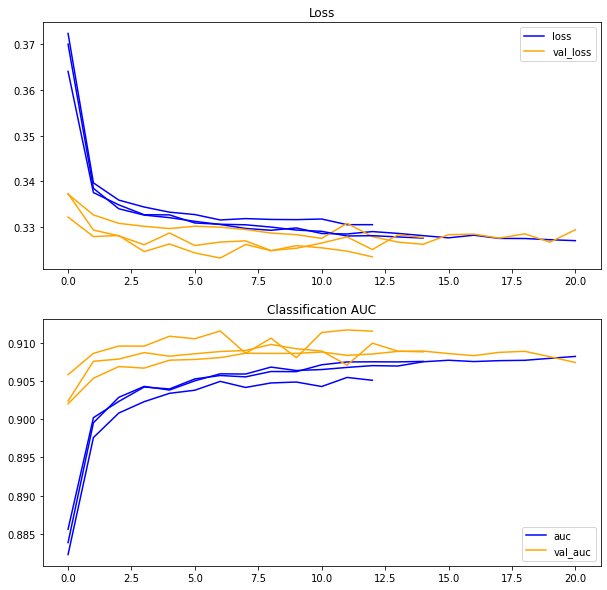

Accuracy: mean=90.930 std=0.171, n=3


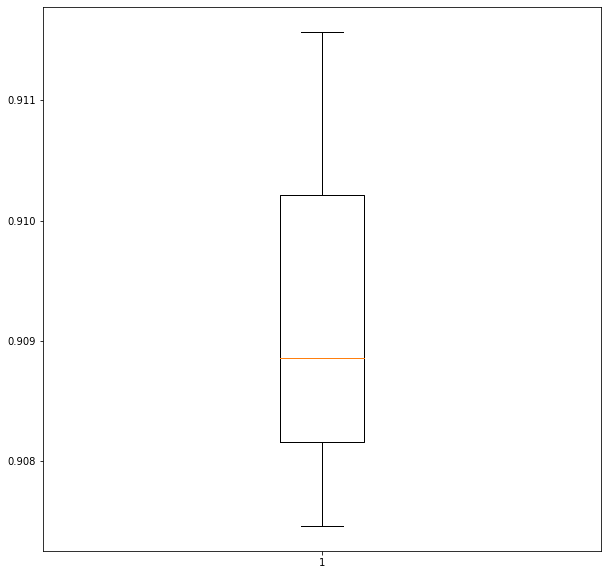

Scores:  [0.9115679860115051, 0.9074611663818359, 0.9088560938835144]
Ensamble test auc:  0.6558945943427891 %


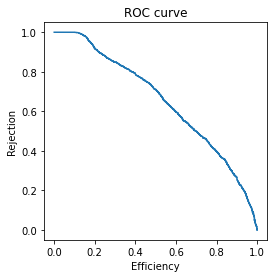

signal_mass =  250
fit_model
compiling
fitting
Epoch 1/100
752/752 [==============================] - 4s 5ms/step - loss: 0.4586 - auc: 0.8325 - val_loss: 0.3854 - val_auc: 0.8798
Epoch 2/100
752/752 [==============================] - 3s 5ms/step - loss: 0.3919 - auc: 0.8708 - val_loss: 0.3825 - val_auc: 0.8822
Epoch 3/100
752/752 [==============================] - 3s 4ms/step - loss: 0.3856 - auc: 0.8764 - val_loss: 0.3808 - val_auc: 0.8834
Epoch 4/100
752/752 [==============================] - 3s 4ms/step - loss: 0.3834 - auc: 0.8778 - val_loss: 0.3834 - val_auc: 0.8832
Epoch 5/100
752/752 [==============================] - 3s 4ms/step - loss: 0.3815 - auc: 0.8803 - val_loss: 0.3802 - val_auc: 0.8834
Epoch 6/100
752/752 [==============================] - 3s 4ms/step - loss: 0.3800 - auc: 0.8805 - val_loss: 0.3806 - val_auc: 0.8835
Epoch 7/100
752/752 [==============================] - 3s 4ms/step - loss: 0.3810 - auc: 0.8801 - val_loss: 0.3807 - val_auc: 0.8838
Epoch 8/100
752/752 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


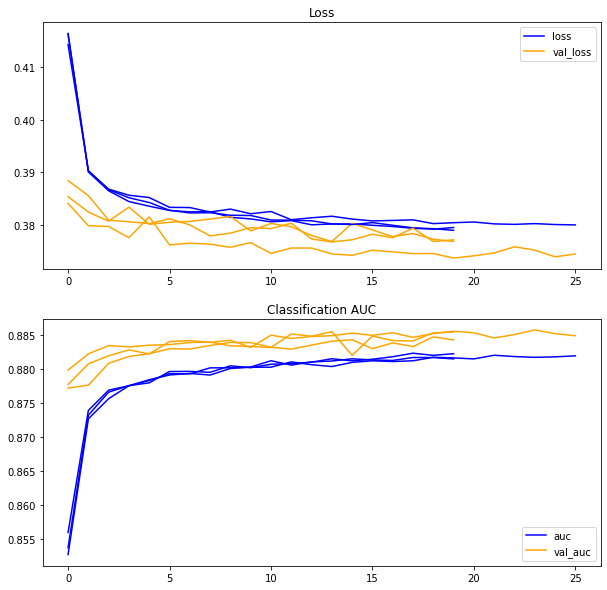

Accuracy: mean=88.481 std=0.047, n=3


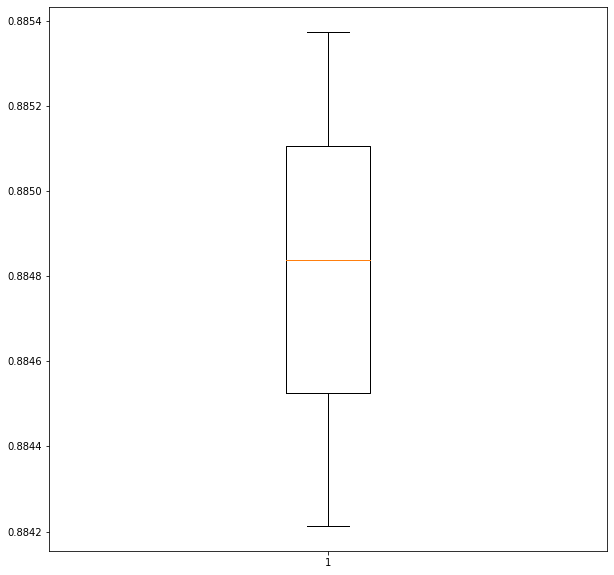

Scores:  [0.8853737711906433, 0.8848379850387573, 0.8842130303382874]
Ensamble test auc:  0.7459216379036657 %


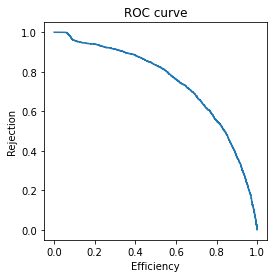

signal_mass =  300
fit_model
compiling
fitting
Epoch 1/100
914/914 [==============================] - 5s 5ms/step - loss: 0.4530 - auc: 0.8357 - val_loss: 0.4002 - val_auc: 0.8738
Epoch 2/100
914/914 [==============================] - 4s 4ms/step - loss: 0.4053 - auc: 0.8697 - val_loss: 0.3987 - val_auc: 0.8751
Epoch 3/100
914/914 [==============================] - 4s 4ms/step - loss: 0.4053 - auc: 0.8701 - val_loss: 0.3982 - val_auc: 0.8759
Epoch 4/100
914/914 [==============================] - 4s 5ms/step - loss: 0.4021 - auc: 0.8723 - val_loss: 0.3999 - val_auc: 0.8741
Epoch 5/100
914/914 [==============================] - 4s 4ms/step - loss: 0.3985 - auc: 0.8744 - val_loss: 0.3977 - val_auc: 0.8761
Epoch 6/100
914/914 [==============================] - 4s 4ms/step - loss: 0.4001 - auc: 0.8732 - val_loss: 0.3968 - val_auc: 0.8765
Epoch 7/100
914/914 [==============================] - 4s 5ms/step - loss: 0.4002 - auc: 0.8735 - val_loss: 0.3965 - val_auc: 0.8767
Epoch 8/100
914/914 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


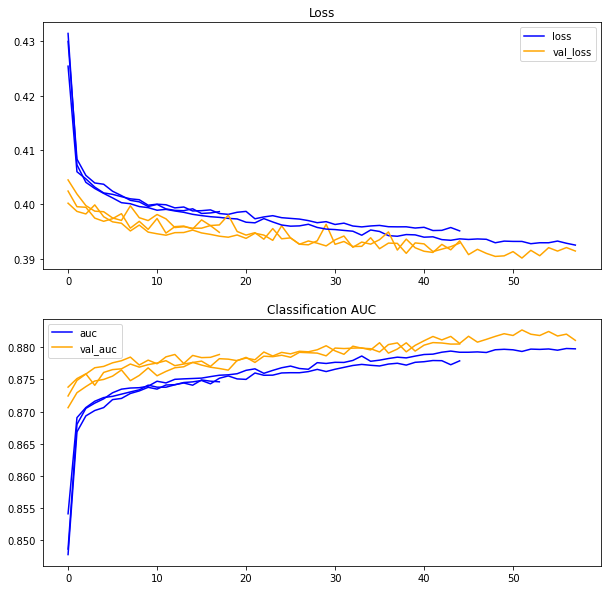

Accuracy: mean=88.016 std=0.093, n=3


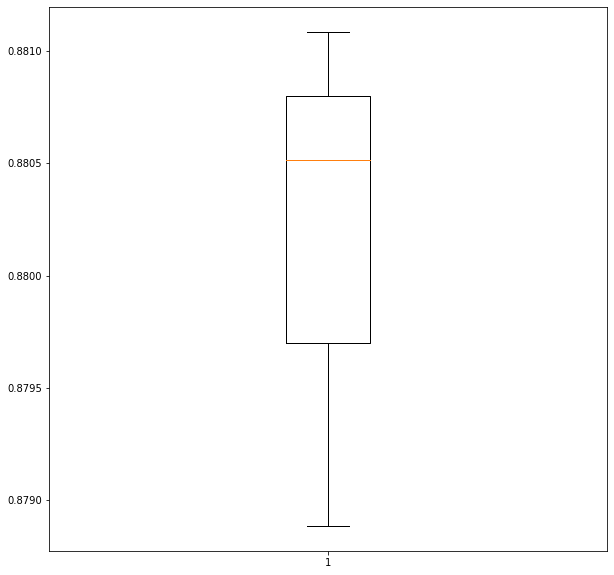

Scores:  [0.8805172443389893, 0.8810855150222778, 0.8788857460021973]
Ensamble test auc:  0.7990865631846926 %


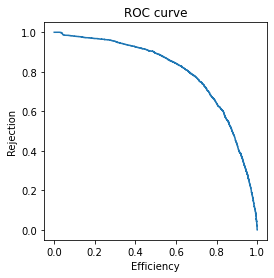

signal_mass =  350
fit_model
compiling
fitting
Epoch 1/100
1030/1030 [==============================] - 5s 4ms/step - loss: 0.4759 - auc: 0.8167 - val_loss: 0.4279 - val_auc: 0.8578
Epoch 2/100
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4303 - auc: 0.8565 - val_loss: 0.4264 - val_auc: 0.8589
Epoch 3/100
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4307 - auc: 0.8553 - val_loss: 0.4258 - val_auc: 0.8594
Epoch 4/100
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4286 - auc: 0.8579 - val_loss: 0.4262 - val_auc: 0.8602
Epoch 5/100
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4269 - auc: 0.8592 - val_loss: 0.4232 - val_auc: 0.8611
Epoch 6/100
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4243 - auc: 0.8614 - val_loss: 0.4262 - val_auc: 0.8611
Epoch 7/100
1030/1030 [==============================] - 4s 4ms/step - loss: 0.4267 - auc: 0.8597 - val_loss: 0.4235 - val_auc: 0.8617
Epoch 8/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


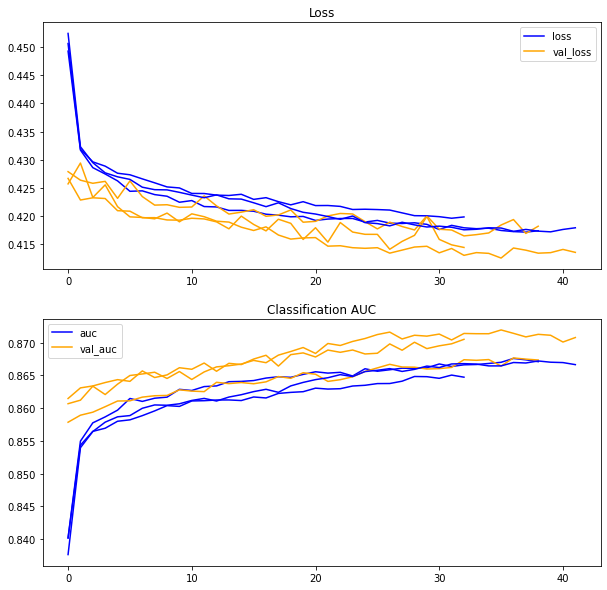

Accuracy: mean=86.957 std=0.156, n=3


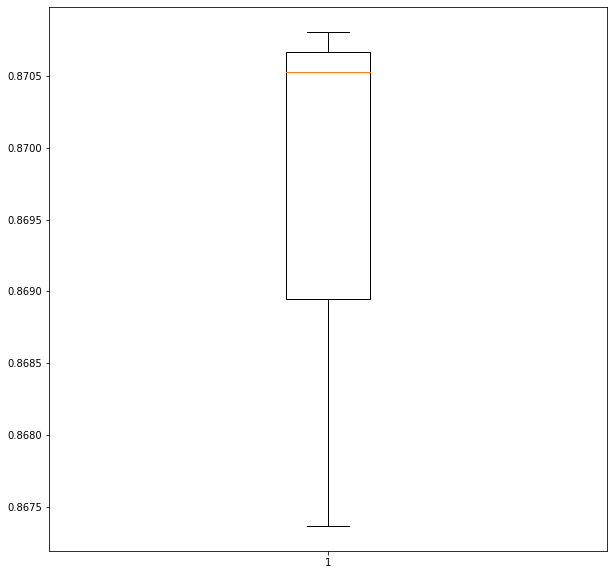

Scores:  [0.8673656582832336, 0.8705307245254517, 0.8708064556121826]
Ensamble test auc:  0.8533837040790182 %


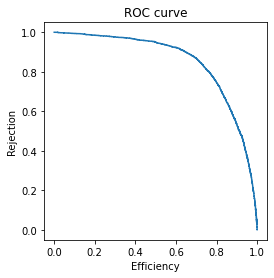

signal_mass =  400
fit_model
compiling
fitting
Epoch 1/100
1109/1109 [==============================] - 6s 5ms/step - loss: 0.5005 - auc: 0.7993 - val_loss: 0.4504 - val_auc: 0.8459
Epoch 2/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.4600 - auc: 0.8371 - val_loss: 0.4483 - val_auc: 0.8480
Epoch 3/100
1109/1109 [==============================] - 4s 4ms/step - loss: 0.4547 - auc: 0.8417 - val_loss: 0.4473 - val_auc: 0.8492
Epoch 4/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.4554 - auc: 0.8402 - val_loss: 0.4443 - val_auc: 0.8501
Epoch 5/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.4546 - auc: 0.8422 - val_loss: 0.4454 - val_auc: 0.8503
Epoch 6/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.4523 - auc: 0.8439 - val_loss: 0.4453 - val_auc: 0.8500
Epoch 7/100
1109/1109 [==============================] - 5s 4ms/step - loss: 0.4525 - auc: 0.8438 - val_loss: 0.4446 - val_auc: 0.8507
Epoch 8/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


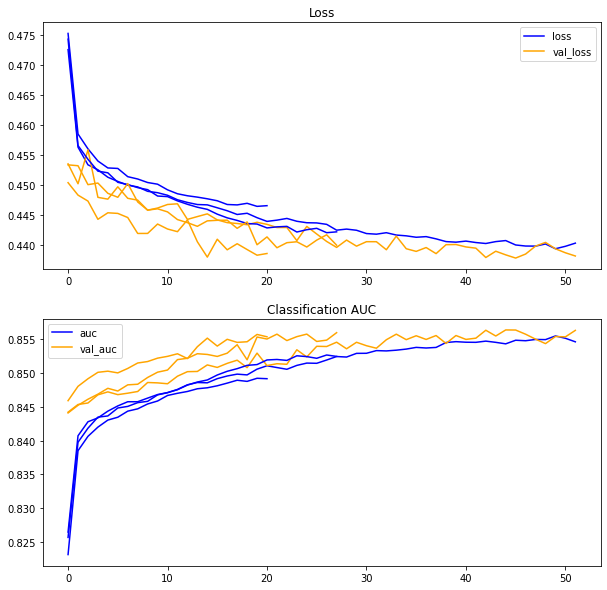

Accuracy: mean=85.589 std=0.039, n=3


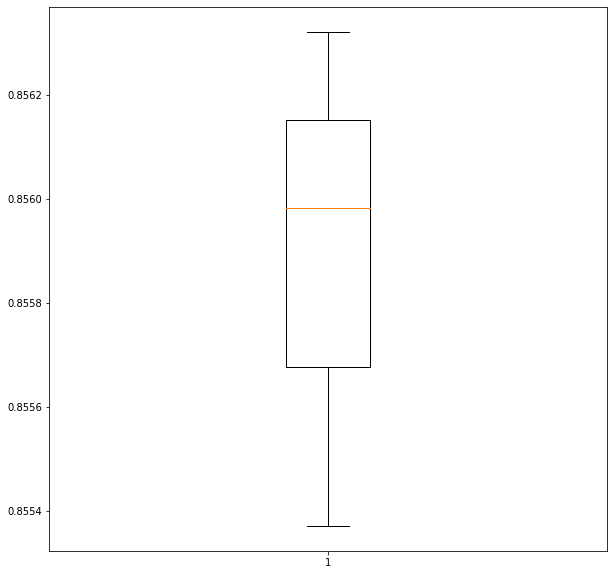

Scores:  [0.8553715944290161, 0.8563207983970642, 0.8559816479682922]
Ensamble test auc:  0.8771164860638361 %


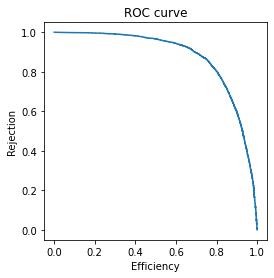

signal_mass =  500
fit_model
compiling
fitting
Epoch 1/100
1201/1201 [==============================] - 6s 4ms/step - loss: 0.5340 - auc: 0.7799 - val_loss: 0.4967 - val_auc: 0.8145
Epoch 2/100
1201/1201 [==============================] - 5s 4ms/step - loss: 0.4970 - auc: 0.8140 - val_loss: 0.4934 - val_auc: 0.8189
Epoch 3/100
1201/1201 [==============================] - 5s 4ms/step - loss: 0.4943 - auc: 0.8164 - val_loss: 0.4934 - val_auc: 0.8194
Epoch 4/100
1201/1201 [==============================] - 5s 4ms/step - loss: 0.4918 - auc: 0.8173 - val_loss: 0.4885 - val_auc: 0.8212
Epoch 5/100
1201/1201 [==============================] - 5s 4ms/step - loss: 0.4903 - auc: 0.8189 - val_loss: 0.4887 - val_auc: 0.8221
Epoch 6/100
1201/1201 [==============================] - 4s 4ms/step - loss: 0.4894 - auc: 0.8200 - val_loss: 0.4864 - val_auc: 0.8233
Epoch 7/100
1201/1201 [==============================] - 5s 5ms/step - loss: 0.4891 - auc: 0.8207 - val_loss: 0.4839 - val_auc: 0.8273
Epoch 8/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


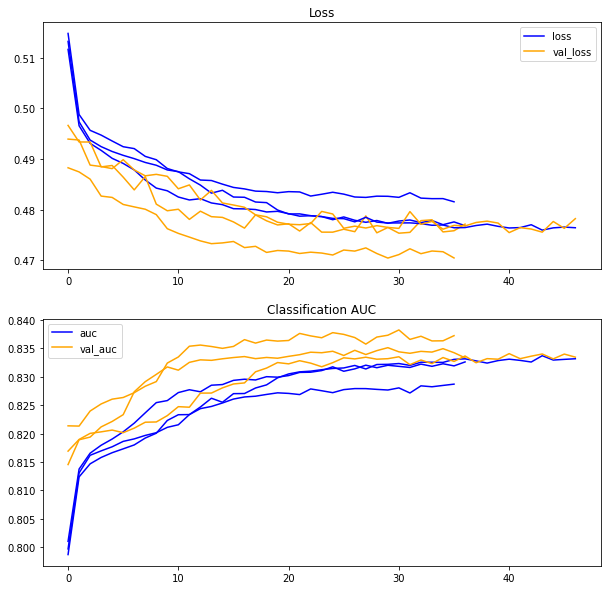

Accuracy: mean=83.465 std=0.181, n=3


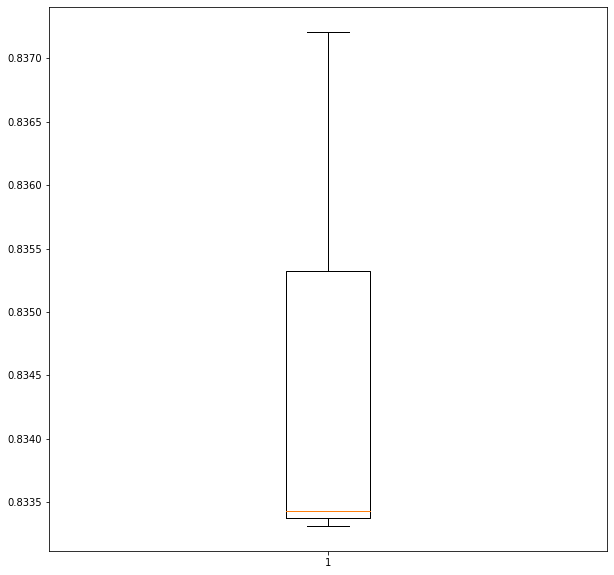

Scores:  [0.8333117961883545, 0.8372096419334412, 0.8334327936172485]
Ensamble test auc:  0.9286498433223918 %


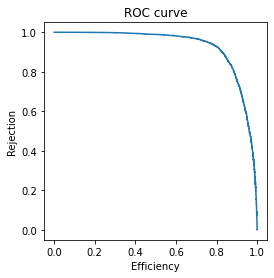

signal_mass =  600
fit_model
compiling
fitting
Epoch 1/100
930/930 [==============================] - 5s 5ms/step - loss: 0.6159 - auc: 0.7076 - val_loss: 0.5750 - val_auc: 0.7520
Epoch 2/100
930/930 [==============================] - 5s 5ms/step - loss: 0.5812 - auc: 0.7465 - val_loss: 0.5739 - val_auc: 0.7541
Epoch 3/100
930/930 [==============================] - 4s 5ms/step - loss: 0.5786 - auc: 0.7472 - val_loss: 0.5712 - val_auc: 0.7552
Epoch 4/100
930/930 [==============================] - 4s 4ms/step - loss: 0.5745 - auc: 0.7519 - val_loss: 0.5705 - val_auc: 0.7575
Epoch 5/100
930/930 [==============================] - 4s 4ms/step - loss: 0.5726 - auc: 0.7554 - val_loss: 0.5665 - val_auc: 0.7624
Epoch 6/100
930/930 [==============================] - 4s 5ms/step - loss: 0.5698 - auc: 0.7580 - val_loss: 0.5642 - val_auc: 0.7671
Epoch 7/100
930/930 [==============================] - 4s 4ms/step - loss: 0.5672 - auc: 0.7618 - val_loss: 0.5585 - val_auc: 0.7723
Epoch 8/100
930/930 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


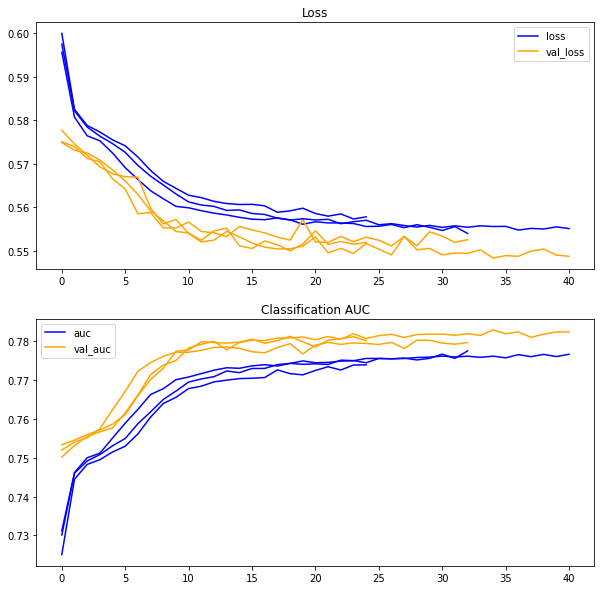

Accuracy: mean=78.076 std=0.119, n=3


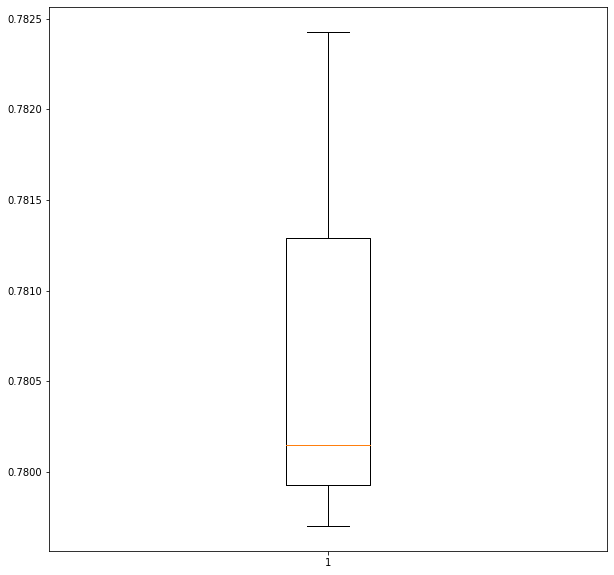

Scores:  [0.7797021269798279, 0.7824267745018005, 0.7801507711410522]
Ensamble test auc:  0.9574852970758008 %


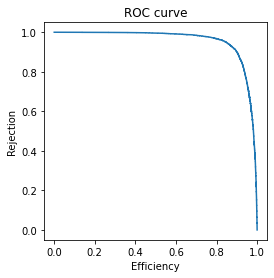

signal_mass =  700
fit_model
compiling
fitting
Epoch 1/100
922/922 [==============================] - 6s 5ms/step - loss: 0.6256 - auc: 0.6933 - val_loss: 0.5875 - val_auc: 0.7455
Epoch 2/100
922/922 [==============================] - 4s 5ms/step - loss: 0.5953 - auc: 0.7351 - val_loss: 0.5828 - val_auc: 0.7505
Epoch 3/100
922/922 [==============================] - 4s 4ms/step - loss: 0.5885 - auc: 0.7420 - val_loss: 0.5800 - val_auc: 0.7519
Epoch 4/100
922/922 [==============================] - 4s 5ms/step - loss: 0.5889 - auc: 0.7407 - val_loss: 0.5789 - val_auc: 0.7525
Epoch 5/100
922/922 [==============================] - 4s 4ms/step - loss: 0.5853 - auc: 0.7445 - val_loss: 0.5783 - val_auc: 0.7532
Epoch 6/100
922/922 [==============================] - 4s 4ms/step - loss: 0.5854 - auc: 0.7436 - val_loss: 0.5772 - val_auc: 0.7545
Epoch 7/100
922/922 [==============================] - 4s 4ms/step - loss: 0.5867 - auc: 0.7421 - val_loss: 0.5793 - val_auc: 0.7572
Epoch 8/100
922/922 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


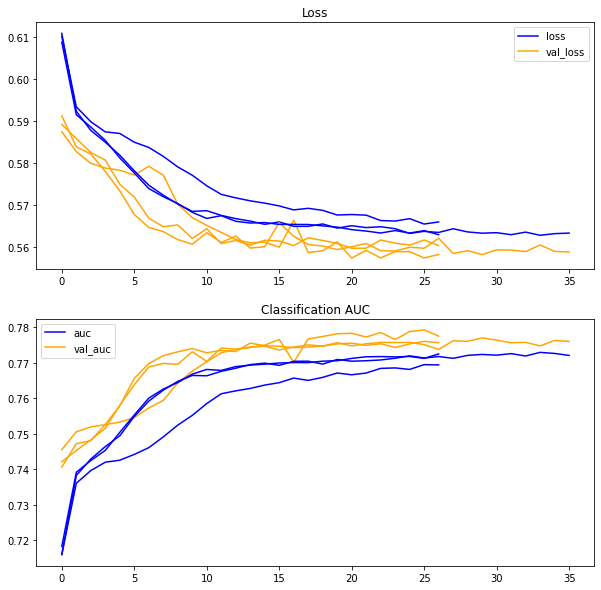

Accuracy: mean=77.632 std=0.080, n=3


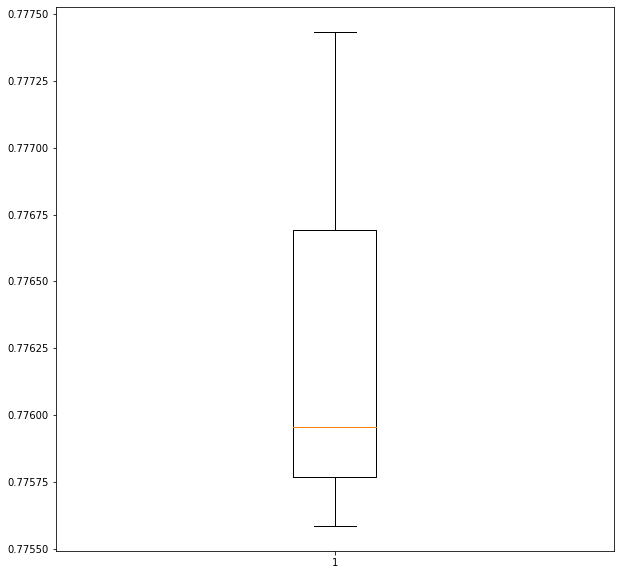

Scores:  [0.7774338126182556, 0.775954008102417, 0.7755841016769409]
Ensamble test auc:  0.9716166052967821 %


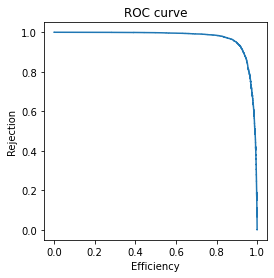

signal_mass =  800
fit_model
compiling
fitting
Epoch 1/100
912/912 [==============================] - 5s 5ms/step - loss: 0.6071 - auc: 0.7200 - val_loss: 0.5785 - val_auc: 0.7533
Epoch 2/100
912/912 [==============================] - 5s 5ms/step - loss: 0.5840 - auc: 0.7462 - val_loss: 0.5734 - val_auc: 0.7595
Epoch 3/100
912/912 [==============================] - 4s 5ms/step - loss: 0.5772 - auc: 0.7549 - val_loss: 0.5696 - val_auc: 0.7642
Epoch 4/100
912/912 [==============================] - 4s 4ms/step - loss: 0.5724 - auc: 0.7598 - val_loss: 0.5640 - val_auc: 0.7709
Epoch 5/100
912/912 [==============================] - 4s 5ms/step - loss: 0.5717 - auc: 0.7614 - val_loss: 0.5597 - val_auc: 0.7748
Epoch 6/100
912/912 [==============================] - 4s 5ms/step - loss: 0.5668 - auc: 0.7676 - val_loss: 0.5598 - val_auc: 0.7774
Epoch 7/100
912/912 [==============================] - 4s 5ms/step - loss: 0.5630 - auc: 0.7720 - val_loss: 0.5516 - val_auc: 0.7838
Epoch 8/100
912/912 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


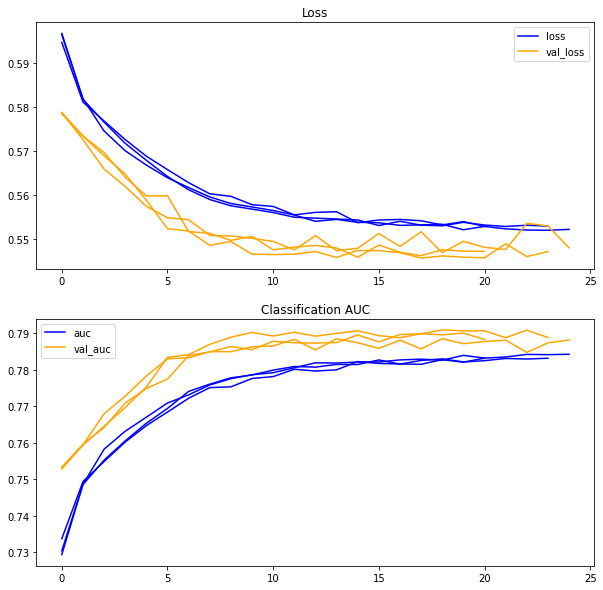

Accuracy: mean=78.840 std=0.029, n=3


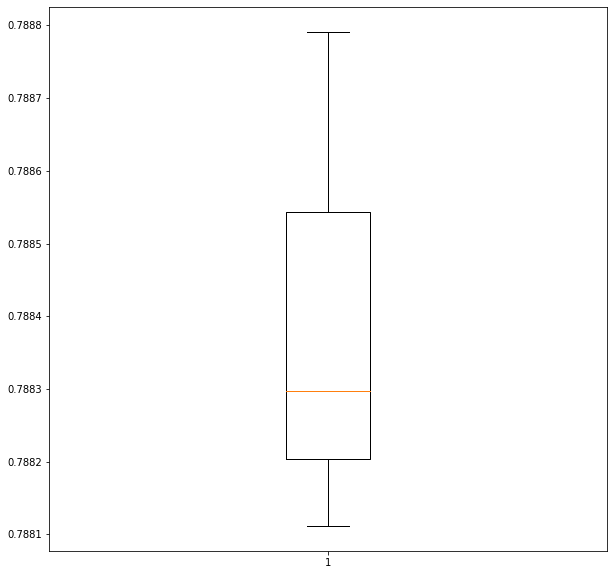

Scores:  [0.788296639919281, 0.7887911796569824, 0.7881112694740295]
Ensamble test auc:  0.9822041456606961 %


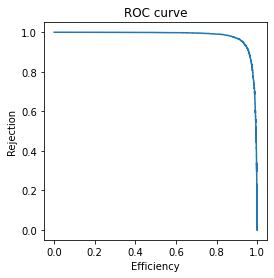

signal_mass =  1200
fit_model
compiling
fitting
Epoch 1/100
670/670 [==============================] - 4s 6ms/step - loss: 0.3697 - auc: 0.9154 - val_loss: 0.2978 - val_auc: 0.9458
Epoch 2/100
670/670 [==============================] - 3s 5ms/step - loss: 0.3084 - auc: 0.9409 - val_loss: 0.2891 - val_auc: 0.9483
Epoch 3/100
670/670 [==============================] - 3s 4ms/step - loss: 0.3026 - auc: 0.9433 - val_loss: 0.2886 - val_auc: 0.9485
Epoch 4/100
670/670 [==============================] - 3s 4ms/step - loss: 0.2986 - auc: 0.9448 - val_loss: 0.2842 - val_auc: 0.9499
Epoch 5/100
670/670 [==============================] - 3s 4ms/step - loss: 0.2970 - auc: 0.9452 - val_loss: 0.2858 - val_auc: 0.9508
Epoch 6/100
670/670 [==============================] - 3s 4ms/step - loss: 0.2929 - auc: 0.9469 - val_loss: 0.2793 - val_auc: 0.9517
Epoch 7/100
670/670 [==============================] - 3s 4ms/step - loss: 0.2936 - auc: 0.9466 - val_loss: 0.2769 - val_auc: 0.9527
Epoch 8/100
670/670 [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


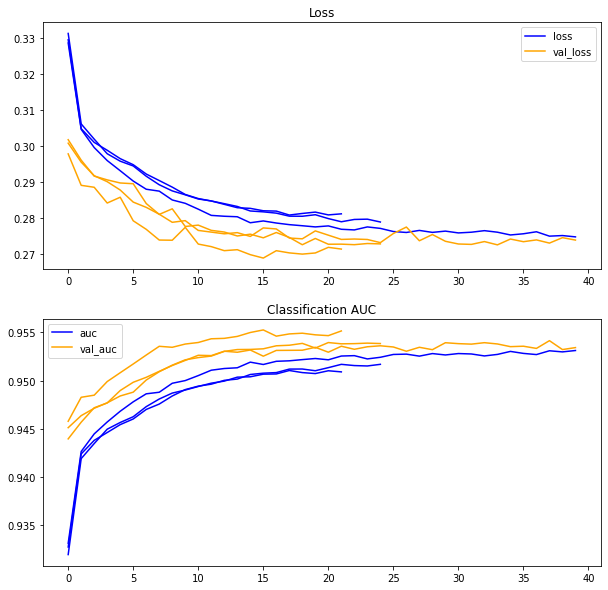

Accuracy: mean=95.414 std=0.074, n=3


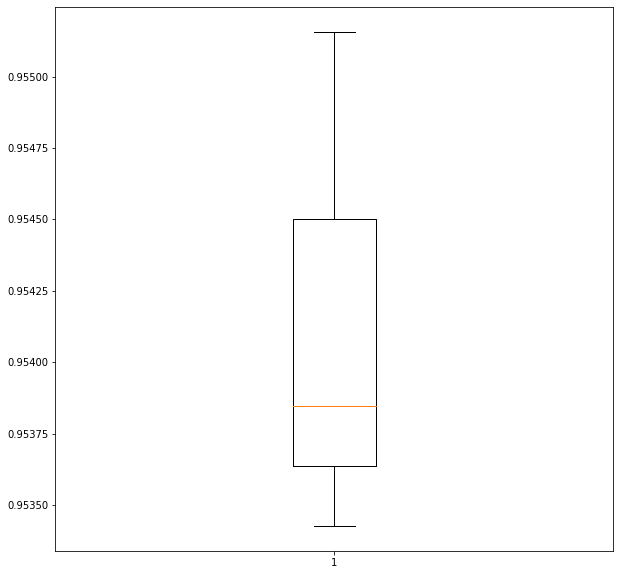

Scores:  [0.9551562070846558, 0.953848659992218, 0.9534274339675903]
Ensamble test auc:  0.995040054344857 %


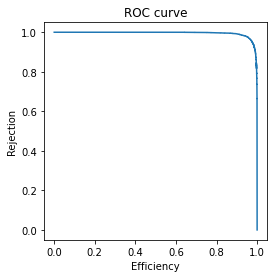

signal_mass =  1500
fit_model
compiling
fitting
Epoch 1/100
517/517 [==============================] - 3s 5ms/step - loss: 0.2336 - auc: 0.9675 - val_loss: 0.1470 - val_auc: 0.9860
Epoch 2/100
517/517 [==============================] - 2s 4ms/step - loss: 0.1546 - auc: 0.9841 - val_loss: 0.1420 - val_auc: 0.9869
Epoch 3/100
517/517 [==============================] - 2s 4ms/step - loss: 0.1498 - auc: 0.9852 - val_loss: 0.1399 - val_auc: 0.9874
Epoch 4/100
517/517 [==============================] - 2s 4ms/step - loss: 0.1470 - auc: 0.9859 - val_loss: 0.1395 - val_auc: 0.9876
Epoch 5/100
517/517 [==============================] - 2s 5ms/step - loss: 0.1458 - auc: 0.9862 - val_loss: 0.1383 - val_auc: 0.9877
Epoch 6/100
517/517 [==============================] - 3s 5ms/step - loss: 0.1418 - auc: 0.9868 - val_loss: 0.1400 - val_auc: 0.9881
Epoch 7/100
517/517 [==============================] - 3s 5ms/step - loss: 0.1424 - auc: 0.9866 - val_loss: 0.1355 - val_auc: 0.9882
Epoch 8/100
517/517 [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


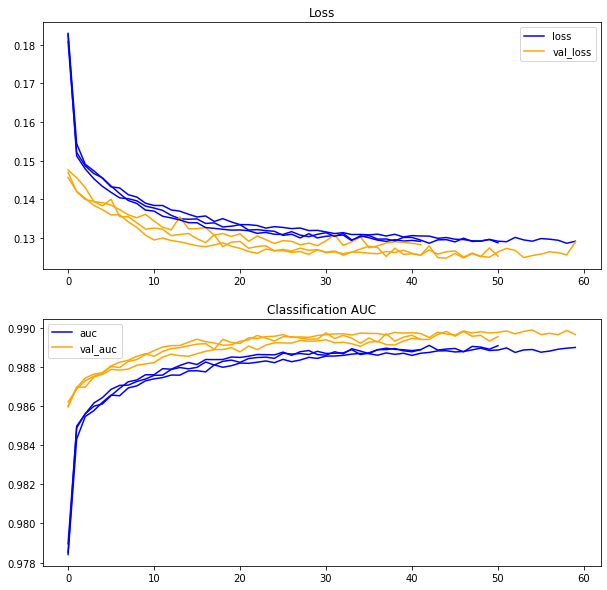

Accuracy: mean=98.955 std=0.009, n=3


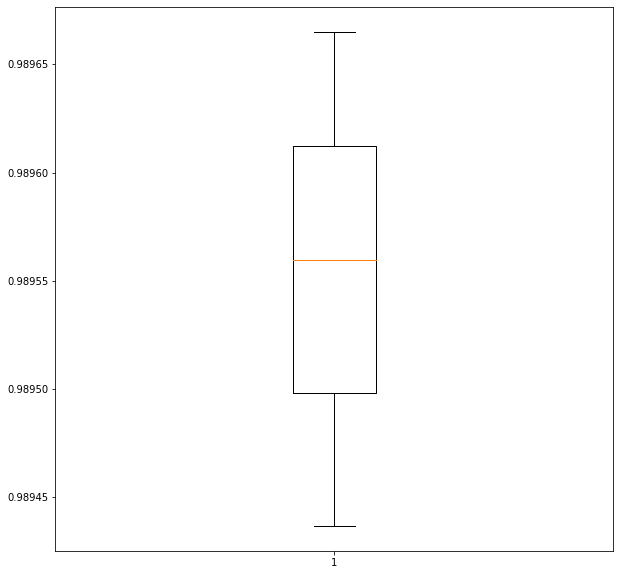

Scores:  [0.9896650314331055, 0.9894365668296814, 0.9895594716072083]
Ensamble test auc:  0.9987700577103752 %


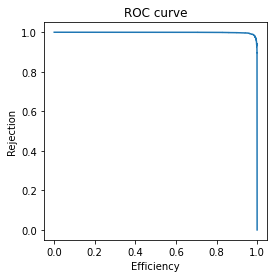

signal_mass =  2000
fit_model
compiling
fitting
Epoch 1/100
431/431 [==============================] - 3s 5ms/step - loss: 0.1644 - auc: 0.9757 - val_loss: 0.0603 - val_auc: 0.9965
Epoch 2/100
431/431 [==============================] - 2s 4ms/step - loss: 0.0613 - auc: 0.9961 - val_loss: 0.0550 - val_auc: 0.9972
Epoch 3/100
431/431 [==============================] - 2s 4ms/step - loss: 0.0579 - auc: 0.9965 - val_loss: 0.0534 - val_auc: 0.9970
Epoch 4/100
431/431 [==============================] - 2s 4ms/step - loss: 0.0584 - auc: 0.9964 - val_loss: 0.0528 - val_auc: 0.9971
Epoch 5/100
431/431 [==============================] - 2s 5ms/step - loss: 0.0571 - auc: 0.9967 - val_loss: 0.0519 - val_auc: 0.9971
Epoch 6/100
431/431 [==============================] - 2s 4ms/step - loss: 0.0534 - auc: 0.9968 - val_loss: 0.0509 - val_auc: 0.9973
Epoch 7/100
431/431 [==============================] - 2s 4ms/step - loss: 0.0526 - auc: 0.9970 - val_loss: 0.0515 - val_auc: 0.9976
Epoch 8/100
431/431 [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


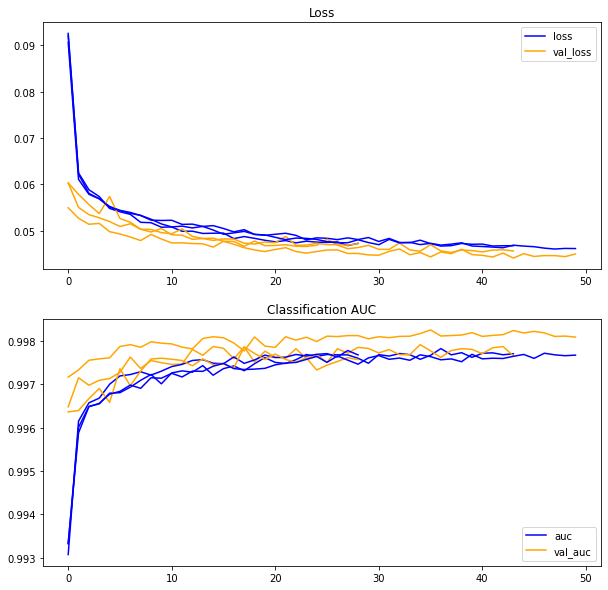

Accuracy: mean=99.777 std=0.023, n=3


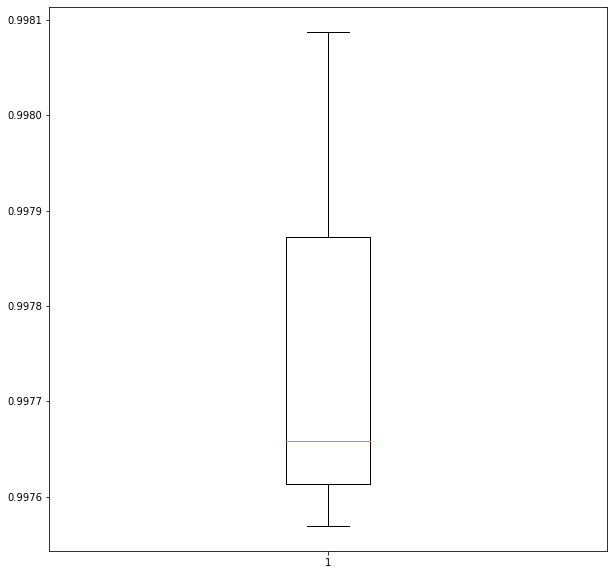

Scores:  [0.9976580739021301, 0.9975691437721252, 0.998087465763092]
Ensamble test auc:  0.9995231432838958 %


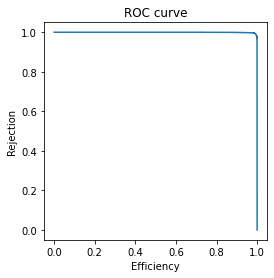

signal_mass =  2500
fit_model
compiling
fitting
Epoch 1/100
366/366 [==============================] - 3s 6ms/step - loss: 0.1418 - auc: 0.9857 - val_loss: 0.0347 - val_auc: 0.9982
Epoch 2/100
366/366 [==============================] - 2s 4ms/step - loss: 0.0386 - auc: 0.9981 - val_loss: 0.0323 - val_auc: 0.9985
Epoch 3/100
366/366 [==============================] - 2s 5ms/step - loss: 0.0366 - auc: 0.9983 - val_loss: 0.0307 - val_auc: 0.9985
Epoch 4/100
366/366 [==============================] - 2s 5ms/step - loss: 0.0329 - auc: 0.9987 - val_loss: 0.0306 - val_auc: 0.9985
Epoch 5/100
366/366 [==============================] - 2s 5ms/step - loss: 0.0338 - auc: 0.9983 - val_loss: 0.0304 - val_auc: 0.9987
Epoch 6/100
366/366 [==============================] - 2s 5ms/step - loss: 0.0355 - auc: 0.9985 - val_loss: 0.0296 - val_auc: 0.9986
Epoch 7/100
366/366 [==============================] - 2s 5ms/step - loss: 0.0316 - auc: 0.9987 - val_loss: 0.0304 - val_auc: 0.9986
Epoch 8/100
366/366 [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


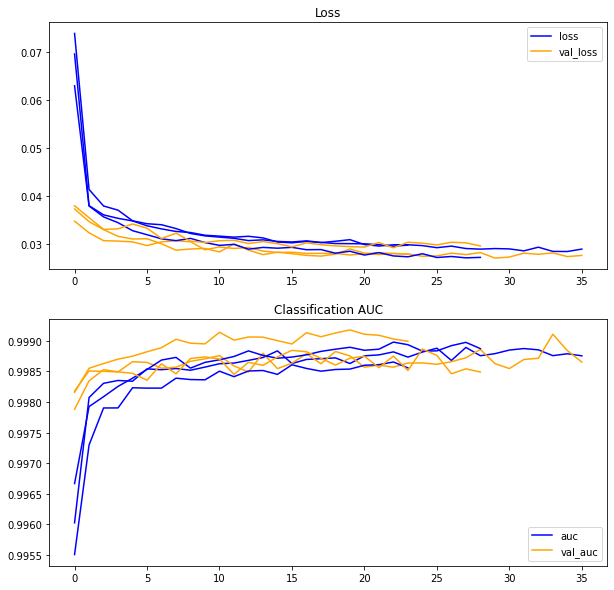

Accuracy: mean=99.871 std=0.021, n=3


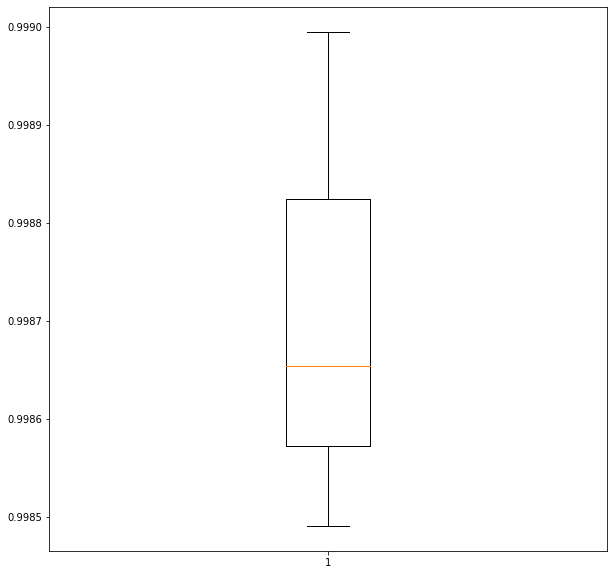

Scores:  [0.9986539483070374, 0.9989950060844421, 0.9984908699989319]
Ensamble test auc:  0.9997943606625285 %


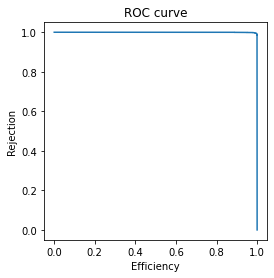

In [37]:
auc_list_sep = []

for m in masses:
  print("signal_mass = ",m)

  #select events with a given signal_mass from the training dataset...
  mask = np.in1d(x_train_all.signal_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[1].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc_list_sep.append(test_ensamble(x_test_m, y_test_m, sw_test_m))

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

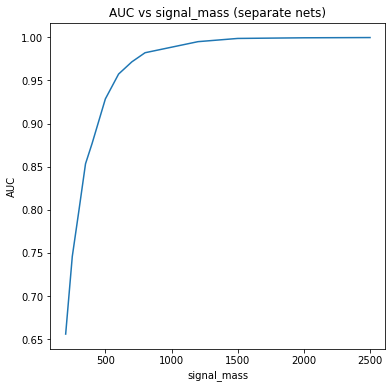

,signal_mass,auc
0,200,0.655895
1,250,0.745922
2,300,0.799087
3,350,0.853384
4,400,0.877116
5,500,0.928650
6,600,0.957485
7,700,0.971617
8,800,0.982204
9,1200,0.995040


In [38]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep)), 
               columns =['signal_mass', 'auc']) 
aucf